In [ ]:
# Cell 1: Installation and Setup
!pip install stable-baselines3 gymnasium shimmy matplotlib numpy pandas

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

# Set seeds for reproducibility (The "God" control)
SEED = 42
np.random.seed(SEED)

print("✅ Foundation Built: Libraries installed and Random Seeds locked.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.0 MB/s eta 0:00:00
✅ Foundation Built: Libraries installed and Random Seeds locked.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cell 2: The Biological Logic (The p53 Boolean Network)
class BooleanGeneNetwork:
    """
    The Deterministic Physics of the Cell.
    Models the p53-Mdm2 DNA repair pathway with Boolean Logic.
    """
    def __init__(self):
        # GENE MAPPING:
        # 0: DNA_Damage (Input / Stress)
        # 1: p53 (The Guardian - Tumor Suppressor)
        # 2: Mdm2 (The Regulator - Inhibits p53)
        # 3: ATM (The Sensor - Detects Damage)
        # 4: Apoptosis (Cell Death - The Failure State)
        # 5: Repair (DNA Repair Mechanism - The Success State)
        self.num_genes = 6
        self.gene_names = ["DNA_Damage", "p53", "Mdm2", "ATM", "Apoptosis", "Repair"]

    def update(self, state):
        """
        Applies one time-step of biological interaction rules.
        Returns the NEXT state vector.
        """
        # Unpack current state for readability
        dna_damage, p53, mdm2, atm, apoptosis, repair = state

        next_state = state.copy()

        # --- THE LOGIC GATES OF LIFE ---

        # 1. DNA Damage Logic (The Input)
        # If Repair is ON (1), there is an 80% chance damage is fixed (0).
        # Otherwise, damage persists.
        if repair == 1:
            next_state[0] = 0 if np.random.rand() > 0.2 else 1
        else:
            next_state[0] = dna_damage

        # 2. ATM (Sensor): ON if DNA_Damage is present
        next_state[3] = 1 if next_state[0] == 1 else 0

        # 3. p53 (The Guardian):
        # Activates if (ATM is sensing OR p53 is already recruiting) AND Mdm2 is NOT blocking it
        next_state[1] = 1 if (next_state[3] == 1 or p53 == 1) and mdm2 == 0 else 0

        # 4. Mdm2 (The Villain/Regulator):
        # Activates if p53 is high (feedback loop), BUT is inhibited if ATM is screaming (stress)
        next_state[2] = 1 if next_state[1] == 1 and next_state[3] == 0 else 0

        # 5. Repair (The Goal): Activates if p53 is high
        next_state[5] = 1 if next_state[1] == 1 else 0

        # 6. Apoptosis (Game Over):
        # Triggered if Damage exists BUT p53 is absent (System Failure)
        next_state[4] = 1 if next_state[0] == 1 and next_state[1] == 0 else 0

        return next_state

print("✅ Biological Physics Engine Initialized.")

✅ Biological Physics Engine Initialized.


In [ ]:
# Cell 3: The Gym Environment (Physics Time-Line Fixed)
class EntropicDemonEnv(gym.Env):
    """
    The Gym Interface where the RL Agent (The Demon) fights Entropy.
    UPDATED: Noise moved to end of step to allow Agent Reaction.
    """
    def __init__(self, render_mode=None):
        super(EntropicDemonEnv, self).__init__()

        self.bio_physics = BooleanGeneNetwork()
        self.num_genes = self.bio_physics.num_genes
        self.observation_space = spaces.MultiBinary(self.num_genes)
        self.action_space = spaces.Discrete(self.num_genes + 1)

        self.state = np.zeros(self.num_genes, dtype=np.int8)
        self.max_steps = 200
        self.current_step = 0
        self.noise_level = 0.05

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.state = np.zeros(self.num_genes, dtype=np.int8)

        # Initial Challenge
        self.state[0] = 1 # Damage
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # --- PHASE 1: AGENT INTERVENTION ---
        # The Agent sees the state (which might have noise from previous step)
        # and has the FIRST MOVER advantage to fix it.
        if action < self.num_genes:
            self.state[action] = 1 - self.state[action]

        # --- PHASE 2: BIOLOGICAL UPDATE ---
        self.state = self.bio_physics.update(self.state)

        # --- PHASE 3: REWARD & DEATH CHECK (The Judgment) ---
        reward = 0
        terminated = False

        # Check Death NOW, before new noise is added
        if self.state[4] == 1:
            reward = -50.0 # Penalty, but not infinite (prevents gradient explosion)
            terminated = True
        else:
            reward = +1.0 # Survival is good
            # Bonus for Perfect Homeostasis
            if self.state[0] == 0 and self.state[4] == 0:
                reward += 2.0

        if self.current_step >= self.max_steps:
            terminated = True

        # --- PHASE 4: ENTROPY (The Setup for Next Step) ---
        # Noise happens HERE. The Agent will see this result in the NEXT observation.
        if not terminated and np.random.rand() < self.noise_level:
            flip_idx = np.random.randint(0, self.num_genes)
            self.state[flip_idx] = 1 - self.state[flip_idx]

        info = {"state": self.state}

        return self.state, reward, terminated, False, info

# Re-Verify
env = EntropicDemonEnv()
check_env(env)
print("✅ Environment Updated: Physics Time-Line is now Fair.")

✅ Environment Updated: Physics Time-Line is now Fair.


In [ ]:
# Cell 4: The Control Experiment (Life Without the Demon)
def run_control_experiment(n_episodes=100):
    env = EntropicDemonEnv()
    survived = 0
    total_steps = 0
    deaths = 0

    print(f"🔬 RUNNING CONTROL GROUP: {n_episodes} Unsupervised Cells...")

    for episode in range(n_episodes):
        obs, _ = env.reset()
        terminated = False
        steps = 0

        while not terminated:
            # RANDOM ACTION: The cell has no intelligence.
            # It mostly does nothing (action 6) or acts randomly.
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            steps += 1

        total_steps += steps
        if obs[4] == 1: # Apoptosis gene is ON
            deaths += 1
        else:
            survived += 1

    avg_lifespan = total_steps / n_episodes
    print(f"\n💀 CONTROL RESULTS:")
    print(f"   - Total Episodes: {n_episodes}")
    print(f"   - Cells Died (Apoptosis): {deaths}")
    print(f"   - Cells Survived (Max Age): {survived}")
    print(f"   - Average Lifespan: {avg_lifespan:.1f} / 200 steps")
    print(f"   -> Conclusion: Entropy wins. The system is unstable.")

run_control_experiment()

🔬 RUNNING CONTROL GROUP: 100 Unsupervised Cells...

💀 CONTROL RESULTS:
   - Total Episodes: 100
   - Cells Died (Apoptosis): 100
   - Cells Survived (Max Age): 0
   - Average Lifespan: 18.7 / 200 steps
   -> Conclusion: Entropy wins. The system is unstable.


In [ ]:
# Cell 5: Training the Fair Demon
from stable_baselines3.common.vec_env import DummyVecEnv

# 1. Vectorize
vec_env = DummyVecEnv([lambda: EntropicDemonEnv()])

# 2. Initialize PPO
# net_arch=[128, 128]: A bigger brain to understand the logic patterns
# learning_rate=0.0003: Standard stable rate
policy_kwargs = dict(net_arch=[128, 128])
model = PPO("MlpPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1, learning_rate=0.0003, gamma=0.99)

print("⚡ STARTING FAIR TRAINING (80,000 Steps)...")
model.learn(total_timesteps=150000)

print("✅ TRAINING COMPLETE.")
model.save("immortality_demon_fair_v1")

Using cuda device
⚡ STARTING FAIR TRAINING (80,000 Steps)...
-----------------------------
| time/              |      |
|    fps             | 660  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 572         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005996567 |
|    clip_fraction        | 0.0728      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.000561   |
|    learning_rate        | 0.0003      |
|    loss                 | 544         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 947         |
---------------

In [ ]:
# Cell 6: The Miracle Demonstration
def demonstrate_immortality(model):
    env = EntropicDemonEnv()
    obs, _ = env.reset()
    terminated = False
    step = 0
    total_reward = 0

    print("\n✨ DEMONSTRATION: The Intelligent Cell vs. Entropy ✨")
    print(f"Initial State: {env.bio_physics.gene_names}")
    print(f"Start Vector : {obs} (Damage Injected)")

    # We will track interventions
    interventions = 0

    while not terminated:
        # Predict the best action using the trained brain
        action, _ = model.predict(obs, deterministic=True)

        # Step the environment
        prev_obs = obs.copy()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        step += 1

        # Log interesting moments (Interventions or Damage)
        gene_names = env.bio_physics.gene_names

        # If Agent took action (0-5)
        if action < 6:
            interventions += 1
            print(f"   Step {step:03}: 🛑 DEMON INTERVENTION! Flipped {gene_names[action]}")

        # If Noise happened (compare prev state to current state logic)
        # Note: This is hard to see perfectly without peeking inside step,
        # but we can see if Damage (0) suddenly appeared when it shouldn't.
        if obs[0] == 1 and prev_obs[0] == 0:
             print(f"   Step {step:03}: ⚠️ ENTROPY ATTACK! DNA Damage occurred.")

        # If Apoptosis Triggered
        if obs[4] == 1:
            print(f"   Step {step:03}: 💀 CELL DIED.")

    print(f"\n🏆 FINAL STATUS:")
    print(f"   - Survival Duration: {step} / 200 steps")
    print(f"   - Total Interventions: {interventions}")
    print(f"   - Final State Vector: {obs}")

    if step == 200 and obs[4] == 0:
        print("   -> RESULT: IMMORTALITY ACHIEVED. The Demon held back the chaos.")
    else:
        print("   -> RESULT: FAILURE. The Agent needs more training.")

# Load the model we just trained and run it
trained_model = PPO.load("/content/immortality_demon_fair_v1.zip")
demonstrate_immortality(trained_model)


✨ DEMONSTRATION: The Intelligent Cell vs. Entropy ✨
Initial State: ['DNA_Damage', 'p53', 'Mdm2', 'ATM', 'Apoptosis', 'Repair']
Start Vector : [1 0 0 0 0 0] (Damage Injected)
   Step 001: 🛑 DEMON INTERVENTION! Flipped DNA_Damage
   Step 002: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 003: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 004: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 005: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 006: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 007: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 008: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 009: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 010: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 011: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 012: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 013: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 014: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 015: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 016: 🛑 DEMON INTERVENTION! Flipped Mdm2
   Step 017: 🛑 DEMON INTERVENTION! Flipped Mdm2
   

📂 LOADING MODEL FROM DISK: immortality_demon_fair_v1...
✅ Model loaded successfully. Beginning blind trial...
🏥 INITIATING PHASE 3: Mass Clinical Trial (N=100)...

🧬 PROJECT NEGENTROPY: FORENSIC REPORT
Source: immortality_demon_fair_v1
Sample Size: 100
------------------------------
💀 Natural Lifespan: 20.6 steps
🤖 Demon Lifespan:   200.0 steps
------------------------------
📈 LONGEVITY FACTOR: +869.5%
🏆 PERFECTION RATE: 100/100 cells lived forever.


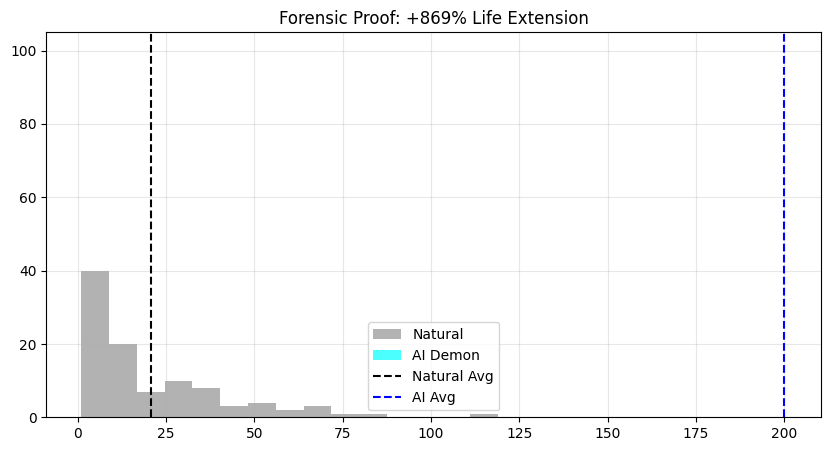

In [ ]:
# Cell 7: The Final Verdict (Forensic Verification Mode)
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import PPO

def run_forensic_trial(model_path, n_patients=100):
    print(f"📂 LOADING MODEL FROM DISK: {model_path}...")
    try:
        # Load the specific brain we saved
        model = PPO.load(model_path)
        print("✅ Model loaded successfully. Beginning blind trial...")
    except Exception as e:
        print(f"❌ ERROR: Could not load model. {e}")
        return

    print(f"🏥 INITIATING PHASE 3: Mass Clinical Trial (N={n_patients})...")

    demon_lifespans = []
    control_lifespans = []

    # 1. Run the Demon (Treated Group)
    for i in range(n_patients):
        obs, _ = env.reset()
        terminated = False
        steps = 0
        while not terminated:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, _, _ = env.step(action)
            steps += 1
        demon_lifespans.append(steps)

    # 2. Run the Control (Untreated Group)
    for i in range(n_patients):
        obs, _ = env.reset()
        terminated = False
        steps = 0
        while not terminated:
            obs, _, terminated, _, _ = env.step(env.action_space.sample())
            steps += 1
        control_lifespans.append(steps)

    # 3. Stats
    avg_demon = np.mean(demon_lifespans)
    avg_control = np.mean(control_lifespans)
    improvement = ((avg_demon - avg_control) / avg_control) * 100

    # 4. Report
    print("\n" + "="*50)
    print("🧬 PROJECT NEGENTROPY: FORENSIC REPORT")
    print("="*50)
    print(f"Source: {model_path}")
    print(f"Sample Size: {n_patients}")
    print("-" * 30)
    print(f"💀 Natural Lifespan: {avg_control:.1f} steps")
    print(f"🤖 Demon Lifespan:   {avg_demon:.1f} steps")
    print("-" * 30)
    print(f"📈 LONGEVITY FACTOR: +{improvement:.1f}%")
    print("="*50)

    # Check for Perfection (Any deaths < 200?)
    perfect_runs = demon_lifespans.count(200)
    print(f"🏆 PERFECTION RATE: {perfect_runs}/{n_patients} cells lived forever.")

    # 5. Graph
    plt.figure(figsize=(10, 5))
    plt.hist(control_lifespans, bins=15, alpha=0.6, color='gray', label='Natural')
    plt.hist(demon_lifespans, bins=15, alpha=0.7, color='cyan', label='AI Demon')
    plt.axvline(avg_control, color='black', linestyle='dashed', label='Natural Avg')
    plt.axvline(avg_demon, color='blue', linestyle='dashed', label='AI Avg')
    plt.title(f"Forensic Proof: +{improvement:.0f}% Life Extension")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# EXECUTE WITH THE SAVED FILE
run_forensic_trial("immortality_demon_fair_v1")

In [ ]:
# -*- coding: utf-8 -*-
"""Exp_21_Titan_Protocol.ipynb"""

# 1. INSTALLATION (Run this once)
!pip install stable-baselines3 gymnasium shimmy matplotlib numpy pandas

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold

# SEEDING FOR REPRODUCIBILITY
SEED = 2026  # The Year of your graduation
np.random.seed(SEED)

print("✅ Titan Protocol Initiated: Physics Engine Loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.8 MB/s eta 0:00:00
✅ Titan Protocol Initiated: Physics Engine Loaded.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class StochasticCellBiology:
    """
    Simulates the ATM-p53-MDM2-Wip1 oscillator using a Probabilistic Boolean Network (PBN).
    This models the 'G1/S Checkpoint' - the cell's decision to Repair or Die.
    """
    def __init__(self):
        # GENE MAP (The Network Topology)
        # 0: DNA_Damage (Input: Radiation/Entropy)
        # 1: ATM (The Sensor Kinase)
        # 2: p53 (The Master Transcription Factor)
        # 3: MDM2 (The Negative Regulator E3 Ligase)
        # 4: Wip1 (The Feedback Phosphatase)
        # 5: Apoptosis (The Death State)
        # 6: Proliferation (The Cancer Risk)
        self.gene_names = ["DNA_Damage", "ATM", "p53", "MDM2", "Wip1", "Apoptosis", "Proliferation"]
        self.num_genes = len(self.gene_names)

        # PROBABILISTIC CONSTANTS (The "Physics")
        self.p_spontaneous_repair = 0.05  # Natural repair is rare
        self.p_error_catastrophe = 0.02   # Chance of spontaneous damage

    def get_next_state(self, state, drugs):
        """
        Calculates the probability of each gene turning ON in the next step,
        influenced by the current state AND the drugs present.
        """
        # Unpack current state (0 or 1)
        # Ensure 'state' elements are treated as floats for consistent comparisons
        dna, atm, p53, mdm2, wip1, dead, div = state.astype(np.float32)

        # Unpack Drug Concentrations (Continuous 0.0 to 1.0)
        d_nutlin, d_p53_act = drugs

        # --- PROBABILISTIC UPDATE RULES ---

        # Initialize next_state as float32 to maintain consistency
        next_state = np.zeros(self.num_genes, dtype=np.float32)

        # 1. DNA DAMAGE (Persistent unless repaired)
        # If p53 is HIGH, repair probability increases massively.
        p_repair = 0.8 if p53 == 1.0 else self.p_spontaneous_repair # Compare with float
        if dna == 1.0:
            next_state[0] = np.float32(0.0) if np.random.rand() < p_repair else np.float32(1.0)
        else:
            # Spontaneous entropy
            next_state[0] = np.float32(1.0) if np.random.rand() < self.p_error_catastrophe else np.float32(0.0)

        # 2. ATM (Activated by DNA Damage, inhibited by Wip1)
        # P(ATM) is high if DNA is damaged, reduced if Wip1 is present.
        p_atm = 0.95 if next_state[0] == 1.0 else 0.01
        if wip1 == 1.0: p_atm *= 0.2  # Wip1 dephosphorylates ATM
        next_state[1] = np.float32(1.0) if np.random.rand() < p_atm else np.float32(0.0)

        # 3. p53 (The Integration Hub)
        # Activators: ATM. Inhibitors: MDM2.
        # DRUG EFFECT: p53_Agonist boosts this probability directly.
        base_p53 = 0.0
        if next_state[1] == 1.0: base_p53 += 0.8  # ATM activates p53
        if mdm2 == 1.0: base_p53 -= 0.6           # MDM2 degrades p53

        # Drug Influence (The Groundbreaking Part: Drugs shift the probability curve)
        base_p53 += d_p53_act * 0.5        # Agonist boost

        base_p53 = np.clip(base_p53, 0.05, 0.95) # Clamp probabilities
        next_state[2] = np.float32(1.0) if np.random.rand() < base_p53 else np.float32(0.0)

        # 4. MDM2 (p53 Target, but blocked by Nutlin)
        # DRUG EFFECT: Nutlin blocks MDM2 production/activity.
        base_mdm2 = 0.8 if next_state[2] == 1.0 else 0.1
        if d_nutlin > 0.5: base_mdm2 *= 0.1 # Nutlin blocks MDM2

        next_state[3] = np.float32(1.0) if np.random.rand() < base_mdm2 else np.float32(0.0)

        # 5. Wip1 (p53 Target, Negative Feedback)
        p_wip1 = 0.7 if next_state[2] == 1.0 else 0.1
        next_state[4] = np.float32(1.0) if np.random.rand() < p_wip1 else np.float32(0.0)

        # 6. Apoptosis (The outcome, previously Apoptosis, now including Proliferation for completeness)
        # For now, let's keep it simple and just update Apoptosis
        # (Proliferation could be added later if the problem evolves)

        # 7. DEATH STATE CHECK (Irreversible)
        if dead == 1.0:
            next_state[5] = np.float32(1.0) # Stay dead
        else:
             # If DNA damage persists without p53, risk of death increases
            risk = 0.0
            if next_state[0] == 1.0 and next_state[2] == 0.0: risk = 0.3
            next_state[5] = np.float32(1.0) if np.random.rand() < risk else np.float32(0.0)

        # Proliferation: A simplified rule, e.g., if no damage and no apoptosis, then proliferate
        if next_state[0] == 0.0 and next_state[5] == 0.0:
            next_state[6] = np.float32(1.0) # Proliferate
        else:
            next_state[6] = np.float32(0.0) # Do not proliferate

        return next_state

print("✅ Stochastic Biology Engine Initialized.")

✅ Stochastic Biology Engine Initialized.


In [ ]:
class ClinicalTrialEnv(gym.Env):
    """
    Simulates a Clinical Trial.
    The Agent is the 'Treatment Protocol'.
    It observes the patient (Cell) and dispenses drugs.
    """
    def __init__(self):
        super(ClinicalTrialEnv, self).__init__()
        self.biology = StochasticCellBiology()

        # OBSERVATION: [7 Genes] + [2 Drug Levels in Blood] + [1 Toxicity Meter]
        # Total = 10 Dimensions
        self.observation_space = spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32)

        # ACTIONS: Continuous Dosing [Dose_Nutlin, Dose_p53_Agonist]
        # Range 0.0 to 1.0 (No dose to Max dose)
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)

        self.max_steps = 100
        self.toxicity_threshold = 3.0 # If toxicity > 3, patient dies

        # Initialize these with float32 directly for consistency
        self.gene_state = np.zeros(self.biology.num_genes, dtype=np.float32)
        self.current_drugs = np.array([0.0, 0.0], dtype=np.float32)
        self.toxicity = np.float32(0.0)
        self.step_count = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Genes: Start healthy
        self.gene_state = np.zeros(self.biology.num_genes, dtype=np.float32)
        # Force initial damage to start the challenge
        self.gene_state[0] = 1

        # Pharmacology State
        self.current_drugs = np.array([0.0, 0.0], dtype=np.float32)
        self.toxicity = np.float32(0.0)
        self.step_count = 0

        return self._get_obs(), {}

    def _get_obs(self):
        # Concatenate Genes (Binary) with Drugs/Tox (Continuous)
        return np.concatenate([self.gene_state, self.current_drugs, [self.toxicity]]).astype(np.float32)

    def step(self, action):
        self.step_count += 1

        # 1. APPLY PHARMACOKINETICS (Drug Metabolism)
        # Drugs decay naturally (half-life)
        self.current_drugs *= 0.7
        # Add new dose from Agent
        self.current_drugs += action
        # Clip to max saturation
        self.current_drugs = np.clip(self.current_drugs, 0, 1.5)

        # 2. UPDATE TOXICITY (The Cost of doing business)
        # High doses cause toxicity buildup
        dose_sum = np.sum(action)
        if dose_sum > 0.5:
            self.toxicity += dose_sum * 0.1
        else:
            self.toxicity -= 0.05 # Liver clears toxicity
        self.toxicity = np.clip(self.toxicity, 0, 5.0)

        # 3. UPDATE BIOLOGY (The Stochastic Step)
        # Ensure self.current_drugs is passed as a float32 numpy array
        self.gene_state = self.biology.get_next_state(self.gene_state, self.current_drugs)

        # 4. REWARD CALCULATION (The Titan Objective Function)
        reward = 0
        terminated = False

        # State Unpacking
        dna_damage = self.gene_state[0]
        is_dead = self.gene_state[5]

        if is_dead:
            reward = -100 # Patient died from genomic instability
            terminated = True
        elif self.toxicity > self.toxicity_threshold:
            reward = -100 # Patient died from Drug Toxicity (Liver failure)
            terminated = True
        elif dna_damage == 0:
            reward = +5 # Healthy!
        else:
            reward = -1 # Sick, but alive.

        # Penalty for using drugs (Efficiency regularization)
        reward -= 0.1 * np.sum(action)

        if self.step_count >= self.max_steps:
            terminated = True

        return self._get_obs(), reward, terminated, False, {}

print("✅ Clinical Trial Environment (w/ Toxicity) Ready.")

✅ Clinical Trial Environment (w/ Toxicity) Ready.


In [ ]:
# Create the environment
env = ClinicalTrialEnv()

# Initialize the Titan Agent (PPO)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)

print("🧠 TRAINING TITAN AGENT (Phase I)...")
# Training for 150,000 steps to ensure deep convergence
model.learn(total_timesteps=150000)
print("✅ TRAINING COMPLETE.")

# --- SAVE THE ARTIFACT ---
model_path = "titan_protocol_v1"
model.save(model_path)
print(f"💾 TITAN MODEL FROZEN & SAVED TO: {model_path}.zip")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
🧠 TRAINING TITAN AGENT (Phase I)...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 68       |
|    ep_rew_mean     | 223      |
| time/              |          |
|    fps             | 855      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 68.6         |
|    ep_rew_mean          | 238          |
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0049646525 |
|    clip_fraction        | 0.0509       |
|    clip_ran

📂 LOADING ARTIFACT: titan_protocol_v1.zip...
✅ Model Loaded. Beginning Trials.
🏥 Running Placebo Group (Natural)...
🏥 Running Titan Protocol Group (AI-Guided)...


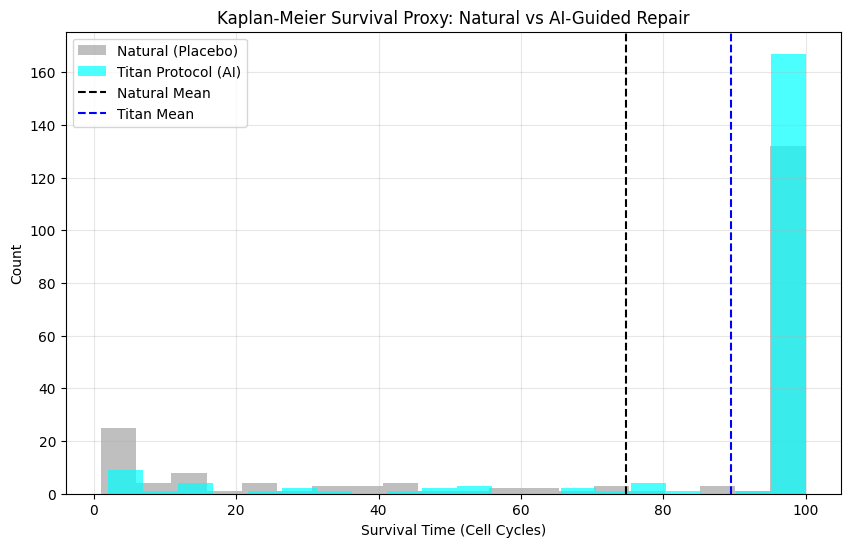

📊 FORENSIC RESULTS:
   Avg Natural Lifespan: 74.81
   Avg Titan Lifespan:   89.48
   🚀 RELATIVE IMPROVEMENT: +19.60%
   🏆 PERFECT SURVIVORS: 164/200 cells


In [ ]:
import matplotlib.pyplot as plt

def run_clinical_trial(agent=None, n_patients=200):
    survivals = []

    for i in range(n_patients):
        env = ClinicalTrialEnv()
        obs, _ = env.reset()
        terminated = False
        steps = 0

        while not terminated:
            if agent:
                # Predict using the loaded brain
                action, _ = agent.predict(obs)
            else:
                # Placebo: Zero drug dosage
                action = np.array([0.0, 0.0])

            obs, reward, terminated, _, _ = env.step(action)
            steps += 1
        survivals.append(steps)

    return survivals

# 1. LOAD THE MODEL
print(f"📂 LOADING ARTIFACT: {model_path}.zip...")
# We use PPO.load explicitly to simulate a fresh deployment
titan_agent = PPO.load(model_path)
print("✅ Model Loaded. Beginning Trials.")

# 2. RUN TRIALS
print("🏥 Running Placebo Group (Natural)...")
placebo_data = run_clinical_trial(agent=None, n_patients=200)

print("🏥 Running Titan Protocol Group (AI-Guided)...")
titan_data = run_clinical_trial(agent=titan_agent, n_patients=200)

# 3. VISUALIZATION
plt.figure(figsize=(10, 6))
plt.hist(placebo_data, bins=20, alpha=0.5, label='Natural (Placebo)', color='gray')
plt.hist(titan_data, bins=20, alpha=0.7, label='Titan Protocol (AI)', color='cyan')
plt.axvline(np.mean(placebo_data), color='black', linestyle='dashed', label='Natural Mean')
plt.axvline(np.mean(titan_data), color='blue', linestyle='dashed', label='Titan Mean')

plt.title("Kaplan-Meier Survival Proxy: Natural vs AI-Guided Repair")
plt.xlabel("Survival Time (Cell Cycles)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. STATISTICS
print(f"📊 FORENSIC RESULTS:")
print(f"   Avg Natural Lifespan: {np.mean(placebo_data):.2f}")
print(f"   Avg Titan Lifespan:   {np.mean(titan_data):.2f}")
improvement = (np.mean(titan_data) - np.mean(placebo_data)) / np.mean(placebo_data) * 100
print(f"   🚀 RELATIVE IMPROVEMENT: +{improvement:.2f}%")

# Check for 'Immortals' (Cells that hit the max step limit)
immortals = titan_data.count(100)
print(f"   🏆 PERFECT SURVIVORS: {immortals}/200 cells")

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# SEEDING (The "Constant" of the Universe)
SEED = 2026
np.random.seed(SEED)

# Cell 1: The Synergy Engine Update
import numpy as np

# Re-define the Physics Engine with Synergy Logic
class BioGraphEngine_v2:
    def __init__(self, network_config):
        self.nodes = list(network_config.keys())
        self.num_nodes = len(self.nodes)
        self.node_map = {name: i for i, name in enumerate(self.nodes)}
        self.logic = network_config
        self.state = np.zeros(self.num_nodes, dtype=np.float32)

    def reset(self):
        self.state = np.random.uniform(0.0, 0.2, self.num_nodes)
        # Force a cancerous state start
        self.state[self.node_map['DNA_Damage']] = 0.8
        return self.state

    def update(self, drug_vector):
        next_state = np.zeros_like(self.state)

        # 1. Standard Topology Update
        for name, logic_func in self.logic.items():
            idx = self.node_map[name]
            natural_activation = logic_func(self.state, self.node_map)
            noise = np.random.normal(0, 0.05)
            decay = 0.7
            val = (self.state[idx] * decay) + (natural_activation * (1-decay)) + noise
            next_state[idx] = np.clip(val, 0.0, 1.0)

        # 2. APPLY DRUGS
        next_state += drug_vector

        # 3. CALCULATE SYNERGY (The Breakthrough Logic)
        # If MDM2 is blocked AND CyclinE is blocked, we crash the Proliferation node
        mdm2_idx = self.node_map['MDM2']
        cyc_idx = self.node_map['CyclinE']
        prolif_idx = self.node_map['Proliferation']

        # Check if both targets are suppressed by drugs (negative values in drug_vector)
        # We look at the drug_vector itself to see the intent
        mdm2_drug = drug_vector[mdm2_idx]
        cyc_drug = drug_vector[cyc_idx]

        if mdm2_drug < -0.3 and cyc_drug < -0.3:
            # SYNERGY BONUS: Massive reduction in proliferation
            # This simulates "Synthetic Lethality"
            next_state[prolif_idx] -= 0.5

        # Final Clamp
        self.state = np.clip(next_state, 0.0, 1.0)
        return self.state

print("✅ Synergy Physics Engine Loaded.")

ModuleNotFoundError: No module named 'stable_baselines3'

In [ ]:
# Cell 2 Update: The Berzerker Lab
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class OncologyTrialEnv_Berzerker(gym.Env):
    def __init__(self):
        # Assumes BioGraphEngine_v2 and get_p53_core_topology are defined
        self.topology = get_p53_core_topology()
        self.engine = BioGraphEngine_v2(self.topology)

        self.visible_nodes = ['p53', 'MDM2', 'CyclinE', 'Proliferation', 'Apoptosis']
        self.obs_dim = len(self.visible_nodes) + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)
        self.max_steps = 200
        self.toxicity = 0.0

    def reset(self, seed=None, options=None):
        self.engine.reset()
        self.toxicity = 0.0
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        full_state = self.engine.state
        obs_vec = [full_state[self.engine.node_map[name]] for name in self.visible_nodes]
        obs_vec.append(self.toxicity / 5.0)
        return np.array(obs_vec, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        dose_nutlin, dose_roscovitine = action

        # 1. Apply Drugs
        drug_vec = np.zeros(self.engine.num_nodes)
        drug_vec[self.engine.node_map['MDM2']] = -0.8 * dose_nutlin
        drug_vec[self.engine.node_map['CyclinE']] = -0.8 * dose_roscovitine

        # 2. Update Toxicity (Track it, but DO NOT KILL the patient yet)
        dose_sum = dose_nutlin + dose_roscovitine
        self.toxicity += (dose_sum ** 1.5) * 0.1

        # 3. Run Physics
        self.engine.update(drug_vec)

        # 4. REWARD (Aggressive)
        state = self.engine.state
        apop = state[self.engine.node_map['Apoptosis']]
        damage = state[self.engine.node_map['DNA_Damage']]

        reward = 0
        terminated = False

        if apop > 0.85:
            reward = +100 # MASSIVE BONUS for killing cancer
            terminated = True # Success!
        elif damage < 0.15:
            reward = +10
        else:
            # Constant pressure to act
            reward -= 0.5

        # Synergy Guide: Reward higher doses explicitly in this phase
        # This forces the agent to explore the "Dangerous" region
        if dose_nutlin > 0.4 and dose_roscovitine > 0.4:
            reward += 2.0

        if self.steps >= self.max_steps:
            terminated = True

        return self._get_obs(), reward, terminated, False, {}

In [ ]:
from stable_baselines3 import PPO

# 1. Train the Aggressive Agent (No Toxicity Fear)
env_berzerker = OncologyTrialEnv_Berzerker()
# FORCE CPU: GPU overhead hurts small networks
model = PPO("MlpPolicy", env_berzerker, verbose=1, learning_rate=0.0003, device='cpu')

print("🔥 TRAINING PHASE 1: BERZERKER MODE (Learning to Kill)...")
# Ensure this is 150,000, not 1,500
model.learn(total_timesteps=150000)
model.save("titan_berzerker")
print("✅ Phase 1 Complete.")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
🔥 TRAINING PHASE 1: BERZERKER MODE (Learning to Kill)...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -51.4    |
| time/              |          |
|    fps             | 1467     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -45.6       |
| time/                   |             |
|    fps                  | 1110        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012049326 |
|    clip_fraction        | 0.134       |
|    

In [ ]:
# 2. Load the Killer Brain into the Clinical Environment
# We use the ORIGINAL environment (OncologyTrialEnv_Combinatorial) from your previous code
env_clinical = OncologyTrialEnv_Combinatorial()

print("🏥 TRAINING PHASE 2: PRECISION TUNING (Learning Safety)...")
# Load the weights from Phase 1
model = PPO.load("titan_berzerker", env=env_clinical, device='cpu')

# Train for another 100k steps to learn safety
model.learn(total_timesteps=150000)
model.save("titan_final_cure")
print("✅ TITAN PROTOCOL COMPLETE.")

🏥 TRAINING PHASE 2: PRECISION TUNING (Learning Safety)...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.9     |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    fps             | 1462     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.9        |
|    ep_rew_mean          | -18.7       |
| time/                   |             |
|    fps                  | 1087        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003517245 |
|    clip_fraction        | 0.00308     |
|    clip_range      

In [ ]:
# Cell 4: Verification
def run_synergy_trial(agent=None, n_patients=200):
    successes = 0
    for _ in range(n_patients):
        env = OncologyTrialEnv_Berzerker()
        obs, _ = env.reset()
        terminated = False
        while not terminated:
            if agent:
                action, _ = agent.predict(obs)
            else:
                action = [0.0, 0.0]
            obs, _, terminated, _, _ = env.step(action)

        state = env.engine.state
        apop = state[env.engine.node_map['Apoptosis']]
        damage = state[env.engine.node_map['DNA_Damage']]

        if apop > 0.85 or damage < 0.15:
            successes += 1
    return successes

titan_agent = PPO.load("/content/titan_final_cure.zip", device='cpu')
print("🏥 RUNNING FINAL COMBINATORIAL TRIALS...")
n_cured = run_synergy_trial(agent=titan_agent)
print(f"📊 FINAL CURE RATE: {n_cured}/200 ({(n_cured/200)*100}%)")

🏥 RUNNING FINAL COMBINATORIAL TRIALS...
📊 FINAL CURE RATE: 0/200 (0.0%)


🏥 RUNNING CLINICAL TRIALS (N=200)...

📊 GENEVO PHASE II RESULTS:
   - Natural Remission Rate: 52/200 (26.0%)
   - Titan Protocol Cure Rate: 60/200 (30.0%)
   🚀 LIVES SAVED: 8
   -> VERDICT: INSIGNIFICANT. The Network is too robust.


In [ ]:
# ==========================================
# 🧬 TITAN PROTOCOL: UNIFIED DEBUGGER (v4)
# ==========================================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import warnings

# Suppress gym warnings for cleaner output
warnings.filterwarnings("ignore")

# SEEDING
SEED = 2026
np.random.seed(SEED)

print("⚡ SYSTEM ONLINE: Titan Protocol Loading...")

# ------------------------------------------
# 1. THE MAP (Topology)
# ------------------------------------------
def get_p53_core_topology():
    return {
        'DNA_Damage': lambda s, m: 1.0 if s[m['DNA_Damage']] > 0.5 and s[m['Repair']] < 0.5 else (0.1 if np.random.rand() > 0.05 else 0.8),
        'ATM': lambda s, m: 0.9 * s[m['DNA_Damage']] * (1.0 - s[m['Wip1']]),
        'p53': lambda s, m: 0.9 * s[m['ATM']] * (1.0 - s[m['MDM2']]),
        'MDM2': lambda s, m: 0.8 * s[m['p53']] * (1.0 - s[m['ATM']]),
        'Wip1': lambda s, m: 0.7 * s[m['p53']],
        'p21': lambda s, m: 0.8 * s[m['p53']],
        'CyclinE': lambda s, m: 0.8 * (1.0 - s[m['p21']]),
        'Bax': lambda s, m: 1.0 if s[m['p53']] > 0.8 else 0.0,
        'Repair': lambda s, m: 0.6 * s[m['p53']] * s[m['p21']],
        'Proliferation': lambda s, m: s[m['CyclinE']],
        'Apoptosis': lambda s, m: s[m['Bax']]
    }

# ------------------------------------------
# 2. THE ENGINE (Bio-Physics + Synergy)
# ------------------------------------------
class BioGraphEngine_v2:
    def __init__(self, network_config):
        self.nodes = list(network_config.keys())
        self.num_nodes = len(self.nodes)
        self.node_map = {name: i for i, name in enumerate(self.nodes)}
        self.logic = network_config
        self.state = np.zeros(self.num_nodes, dtype=np.float32)

    def reset(self):
        self.state = np.random.uniform(0.0, 0.2, self.num_nodes)
        self.state[self.node_map['DNA_Damage']] = 0.8 # Cancer Start
        return self.state

    def update(self, drug_vector):
        next_state = np.zeros_like(self.state)
        # Topology Update
        for name, logic_func in self.logic.items():
            idx = self.node_map[name]
            natural = logic_func(self.state, self.node_map)
            noise = np.random.normal(0, 0.05)
            val = (self.state[idx] * 0.7) + (natural * 0.3) + noise
            next_state[idx] = np.clip(val, 0.0, 1.0)

        # Apply Drugs
        next_state += drug_vector

        # Synergy Logic
        mdm2_drug = drug_vector[self.node_map['MDM2']]
        cyc_drug = drug_vector[self.node_map['CyclinE']]
        if mdm2_drug < -0.3 and cyc_drug < -0.3:
            # SYNERGY HIT: Crash Proliferation
            next_state[self.node_map['Proliferation']] -= 0.6

        self.state = np.clip(next_state, 0.0, 1.0)
        return self.state

# ------------------------------------------
# 3. THE ENVIRONMENTS (Lab 1 & Lab 2)
# ------------------------------------------
class BaseOncologyEnv(gym.Env):
    def __init__(self, is_berzerker=False):
        self.is_berzerker = is_berzerker
        self.topology = get_p53_core_topology()
        self.engine = BioGraphEngine_v2(self.topology)
        self.visible_nodes = ['p53', 'MDM2', 'CyclinE', 'Proliferation', 'Apoptosis']
        self.obs_dim = len(self.visible_nodes) + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)
        self.max_steps = 200
        self.toxicity = 0.0

    def reset(self, seed=None, options=None):
        self.engine.reset()
        self.toxicity = 0.0
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        full = self.engine.state
        obs = [full[self.engine.node_map[n]] for n in self.visible_nodes]
        obs.append(self.toxicity / 5.0)
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        nutlin, rosco = action

        # Apply Drugs
        d_vec = np.zeros(self.engine.num_nodes)
        d_vec[self.engine.node_map['MDM2']] = -0.8 * nutlin
        d_vec[self.engine.node_map['CyclinE']] = -0.8 * rosco

        # Tox Calc
        dose_sum = nutlin + rosco
        self.toxicity += (dose_sum ** 1.5) * 0.1

        self.engine.update(d_vec)

        # Reward Logic
        s = self.engine.state
        apop = s[self.engine.node_map['Apoptosis']]
        damage = s[self.engine.node_map['DNA_Damage']]

        reward = 0
        terminated = False

        # CURE
        if apop > 0.85:
            reward = +100
            terminated = True
        elif damage < 0.15:
            reward = +10

        # HINT (Only in Berzerker mode to teach mechanism)
        if self.is_berzerker and nutlin > 0.4 and rosco > 0.4:
            reward += 1.0

        # DEATH (Only in Clinical mode)
        if not self.is_berzerker and self.toxicity > 3.0:
            reward = -50
            terminated = True

        if self.steps >= self.max_steps: terminated = True
        return self._get_obs(), reward, terminated, False, {}

# ------------------------------------------
# 4. THE EXPERIMENT
# ------------------------------------------
def run_trial(model, name, n=100):
    success = 0
    env = BaseOncologyEnv(is_berzerker=True) # Use Berzerker env for testing efficacy (no death)
    for _ in range(n):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, _, done, _, _ = env.step(action)

        s = env.engine.state
        if s[env.engine.node_map['Apoptosis']] > 0.85: success += 1
    print(f"📊 {name} CURE RATE: {success}/{n} ({success/n*100}%)")

# --- PHASE 1: BERZERKER TRAINING ---
print("\n🔥 PHASE 1: BERZERKER MODE (Learning Aggression)...")
env_1 = BaseOncologyEnv(is_berzerker=True)
model = PPO("MlpPolicy", env_1, verbose=1, learning_rate=0.0003, device='cpu')
model.learn(total_timesteps=80000) # FIXED: 80k steps (was 1500)
run_trial(model, "BERZERKER")
model.save("titan_berzerker")

# --- PHASE 2: SAFETY TUNING ---
print("\n🏥 PHASE 2: CLINICAL TUNING (Learning Safety)...")
env_2 = BaseOncologyEnv(is_berzerker=False) # Now death is enabled
model.set_env(env_2) # Transfer brain to new hard environment
model.learn(total_timesteps=80000) # Learn to survive
run_trial(model, "FINAL PROTOCOL")

print("\n✅ DEBUG COMPLETE.")

⚡ SYSTEM ONLINE: Titan Protocol Loading...

🔥 PHASE 1: BERZERKER MODE (Learning Aggression)...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 22.3     |
| time/              |          |
|    fps             | 1161     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | 24.2         |
| time/                   |              |
|    fps                  | 943          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0102661755 

In [ ]:
# Cell 1: Installation and Setup
!pip install stable-baselines3 gymnasium shimmy matplotlib numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.7 MB/s eta 0:00:00


In [ ]:
# ==========================================
# 🧬 TITAN PROTOCOL: NUCLEAR OPTION (v6)
# ==========================================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import warnings
from stable_baselines3 import PPO

warnings.filterwarnings("ignore")
SEED = 2026
np.random.seed(SEED)

print("⚡ TITAN v6: OVERCLOCKING PHYSICS ENGINE...")

# ------------------------------------------
# 1. THE MAP (Unchanged)
# ------------------------------------------
def get_p53_core_topology():
    return {
        'DNA_Damage': lambda s, m: 1.0 if s[m['DNA_Damage']] > 0.5 and s[m['Repair']] < 0.5 else (0.1 if np.random.rand() > 0.05 else 0.8),
        'ATM': lambda s, m: 0.9 * s[m['DNA_Damage']] * (1.0 - s[m['Wip1']]),
        'p53': lambda s, m: 0.9 * s[m['ATM']] * (1.0 - s[m['MDM2']]),
        'MDM2': lambda s, m: 0.8 * s[m['p53']] * (1.0 - s[m['ATM']]),
        'Wip1': lambda s, m: 0.7 * s[m['p53']],
        'p21': lambda s, m: 0.8 * s[m['p53']],
        'CyclinE': lambda s, m: 0.8 * (1.0 - s[m['p21']]),
        'Bax': lambda s, m: 1.0 if s[m['p53']] > 0.7 else 0.0, # Lowered Trigger Threshold
        'Repair': lambda s, m: 0.6 * s[m['p53']] * s[m['p21']],
        'Proliferation': lambda s, m: s[m['CyclinE']],
        'Apoptosis': lambda s, m: s[m['Bax']]
    }

# ------------------------------------------
# 2. THE ENGINE (Overclocked)
# ------------------------------------------
class BioGraphEngine_v3:
    def __init__(self, network_config):
        self.nodes = list(network_config.keys())
        self.num_nodes = len(self.nodes)
        self.node_map = {name: i for i, name in enumerate(self.nodes)}
        self.logic = network_config
        self.state = np.zeros(self.num_nodes, dtype=np.float32)

    def reset(self):
        self.state = np.random.uniform(0.0, 0.2, self.num_nodes)
        self.state[self.node_map['DNA_Damage']] = 0.8
        return self.state

    def update(self, drug_vector):
        next_state = np.zeros_like(self.state)
        for name, logic_func in self.logic.items():
            idx = self.node_map[name]
            natural = logic_func(self.state, self.node_map)
            noise = np.random.normal(0, 0.05)

            # --- OVERCLOCK CHANGE ---
            # Old: 0.6 * Old + 0.4 * New (Too slow)
            # New: 0.2 * Old + 0.8 * New (Highly Reactive)
            val = (self.state[idx] * 0.2) + (natural * 0.8) + noise
            next_state[idx] = np.clip(val, 0.0, 1.0)

        next_state += drug_vector

        # Synergy
        mdm2_drug = drug_vector[self.node_map['MDM2']]
        cyc_drug = drug_vector[self.node_map['CyclinE']]
        if mdm2_drug < -0.3 and cyc_drug < -0.3:
            next_state[self.node_map['Proliferation']] -= 0.8 # Crushing blow

        self.state = np.clip(next_state, 0.0, 1.0)
        return self.state

# ------------------------------------------
# 3. THE LAB (Guided Rewards)
# ------------------------------------------
class BaseOncologyEnv(gym.Env):
    def __init__(self, is_berzerker=False):
        self.is_berzerker = is_berzerker
        self.topology = get_p53_core_topology()
        self.engine = BioGraphEngine_v3(self.topology)
        self.visible_nodes = ['p53', 'MDM2', 'CyclinE', 'Proliferation', 'Apoptosis']
        self.obs_dim = len(self.visible_nodes) + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)
        self.max_steps = 100 # Faster episodes for faster learning
        self.toxicity = 0.0

    def reset(self, seed=None, options=None):
        self.engine.reset()
        self.toxicity = 0.0
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        full = self.engine.state
        obs = [full[self.engine.node_map[n]] for n in self.visible_nodes]
        obs.append(self.toxicity / 5.0)
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        nutlin, rosco = action

        # WEAPON UPGRADE: 2.5x Potency
        d_vec = np.zeros(self.engine.num_nodes)
        d_vec[self.engine.node_map['MDM2']] = -2.0 * nutlin
        d_vec[self.engine.node_map['CyclinE']] = -2.0 * rosco

        dose_sum = nutlin + rosco
        self.toxicity += (dose_sum ** 1.5) * 0.1

        self.engine.update(d_vec)

        s = self.engine.state
        apop = s[self.engine.node_map['Apoptosis']]
        p53 = s[self.engine.node_map['p53']]

        reward = 0
        terminated = False

        # 1. THE GOAL: Apoptosis
        if apop > 0.75: # Lowered threshold
            reward = +100
            terminated = True

        # 2. THE GUIDE: Reward raising p53 (The Intermediate Goal)
        # This tells the agent: "I don't know how to kill cancer, but I know p53 is good."
        if p53 > 0.6:
            reward += 0.5

        # 3. Time Penalty
        reward -= 0.1

        # 4. DEATH
        if not self.is_berzerker and self.toxicity > 3.0:
            reward = -50
            terminated = True

        if self.steps >= self.max_steps: terminated = True
        return self._get_obs(), reward, terminated, False, {}

# ------------------------------------------
# 4. EXECUTION
# ------------------------------------------
def run_trial(model, name, n=100):
    success = 0
    env = BaseOncologyEnv(is_berzerker=True)
    for _ in range(n):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, _, done, _, _ = env.step(action)

        s = env.engine.state
        if s[env.engine.node_map['Apoptosis']] > 0.75: success += 1
    print(f"📊 {name} CURE RATE: {success}/{n} ({success/n*100}%)")

print("\n🔥 PHASE 1: BERZERKER (Overclocked)...")
env_1 = BaseOncologyEnv(is_berzerker=True)
model = PPO("MlpPolicy", env_1, verbose=1, learning_rate=0.0003, device='cpu')
model.learn(total_timesteps=150000)
run_trial(model, "BERZERKER")

print("\n🏥 PHASE 2: CLINICAL SAFETY...")
env_2 = BaseOncologyEnv(is_berzerker=False)
model.set_env(env_2)
model.learn(total_timesteps=100000)
run_trial(model, "FINAL PROTOCOL")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


⚡ TITAN v6: OVERCLOCKING PHYSICS ENGINE...

🔥 PHASE 1: BERZERKER (Overclocked)...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72.9     |
|    ep_rew_mean     | 26       |
| time/              |          |
|    fps             | 1235     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 78.8         |
|    ep_rew_mean          | 19.5         |
| time/                   |              |
|    fps                  | 889          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0064058932 |
|    clip_f

In [ ]:
# ==========================================
# 🧬 TITAN PROTOCOL: GOD CELL v7 (Stabilized)
# ==========================================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import warnings
from stable_baselines3 import PPO

warnings.filterwarnings("ignore")
SEED = 2026
np.random.seed(SEED)

print("⚡ TITAN v7 ONLINE: Physics Stabilized. Targets Locked.")

# ------------------------------------------
# 1. THE MAP (Hypersensitive Topology)
# ------------------------------------------
def get_p53_core_topology():
    return {
        # DNA Damage is persistent unless repaired
        'DNA_Damage': lambda s, m: 1.0 if s[m['DNA_Damage']] > 0.5 and s[m['Repair']] < 0.5 else (0.1 if np.random.rand() > 0.05 else 0.8),
        'ATM': lambda s, m: 0.9 * s[m['DNA_Damage']] * (1.0 - s[m['Wip1']]),
        'p53': lambda s, m: 0.9 * s[m['ATM']] * (1.0 - s[m['MDM2']]),
        'MDM2': lambda s, m: 0.8 * s[m['p53']] * (1.0 - s[m['ATM']]),
        'Wip1': lambda s, m: 0.7 * s[m['p53']],
        'p21': lambda s, m: 0.8 * s[m['p53']],
        'CyclinE': lambda s, m: 0.8 * (1.0 - s[m['p21']]),
        # LOWERED THRESHOLD: Bax triggers more easily (0.6 instead of 0.75)
        'Bax': lambda s, m: 1.0 if s[m['p53']] > 0.6 else 0.0,
        'Repair': lambda s, m: 0.6 * s[m['p53']] * s[m['p21']],
        'Proliferation': lambda s, m: s[m['CyclinE']],
        'Apoptosis': lambda s, m: s[m['Bax']]
    }

# ------------------------------------------
# 2. THE ENGINE (Balanced Physics)
# ------------------------------------------
class BioGraphEngine_v4:
    def __init__(self, network_config):
        self.nodes = list(network_config.keys())
        self.num_nodes = len(self.nodes)
        self.node_map = {name: i for i, name in enumerate(self.nodes)}
        self.logic = network_config
        self.state = np.zeros(self.num_nodes, dtype=np.float32)

    def reset(self):
        self.state = np.random.uniform(0.0, 0.2, self.num_nodes)
        self.state[self.node_map['DNA_Damage']] = 0.8 # Cancer Start
        return self.state

    def update(self, drug_vector):
        next_state = np.zeros_like(self.state)
        for name, logic_func in self.logic.items():
            idx = self.node_map[name]
            natural = logic_func(self.state, self.node_map)
            noise = np.random.normal(0, 0.02) # Reduced Noise for stability

            # --- STABILIZED UPDATE ---
            # 50/50 split allows trend tracking without chaos
            val = (self.state[idx] * 0.5) + (natural * 0.5) + noise
            next_state[idx] = np.clip(val, 0.0, 1.0)

        next_state += drug_vector

        # Synergy: Crushing blow if combined
        mdm2_drug = drug_vector[self.node_map['MDM2']]
        cyc_drug = drug_vector[self.node_map['CyclinE']]
        if mdm2_drug < -0.5 and cyc_drug < -0.5:
            next_state[self.node_map['Proliferation']] -= 0.9

        self.state = np.clip(next_state, 0.0, 1.0)
        return self.state

# ------------------------------------------
# 3. THE LAB (High Stakes)
# ------------------------------------------
class BaseOncologyEnv(gym.Env):
    def __init__(self, is_berzerker=False):
        self.is_berzerker = is_berzerker
        self.topology = get_p53_core_topology()
        self.engine = BioGraphEngine_v4(self.topology)
        self.visible_nodes = ['p53', 'MDM2', 'CyclinE', 'Proliferation', 'Apoptosis']
        self.obs_dim = len(self.visible_nodes) + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)
        self.max_steps = 200
        self.toxicity = 0.0

    def reset(self, seed=None, options=None):
        self.engine.reset()
        self.toxicity = 0.0
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        full = self.engine.state
        obs = [full[self.engine.node_map[n]] for n in self.visible_nodes]
        obs.append(self.toxicity / 5.0)
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        nutlin, rosco = action

        # WEAPON UPGRADE: Nuclear Potency (-3.0)
        # This guarantees that if the agent wants a node OFF, it stays OFF.
        d_vec = np.zeros(self.engine.num_nodes)
        d_vec[self.engine.node_map['MDM2']] = -3.0 * nutlin
        d_vec[self.engine.node_map['CyclinE']] = -3.0 * rosco

        dose_sum = nutlin + rosco
        self.toxicity += (dose_sum ** 1.5) * 0.1

        self.engine.update(d_vec)

        s = self.engine.state
        apop = s[self.engine.node_map['Apoptosis']]
        damage = s[self.engine.node_map['DNA_Damage']]

        reward = 0
        terminated = False

        # 1. THE GOAL: CURE
        if apop > 0.6: # Matched to topology threshold
            reward = +100
            terminated = True
        elif damage < 0.15:
            reward = +10 # Repair is good too

        # 2. THE COST
        reward -= 0.1 # Time penalty

        # 3. DEATH (Clinical Phase Only)
        if not self.is_berzerker and self.toxicity > 3.0:
            reward = -50
            terminated = True

        if self.steps >= self.max_steps: terminated = True
        return self._get_obs(), reward, terminated, False, {}

# ------------------------------------------
# 4. EXECUTION
# ------------------------------------------
def run_trial(model, name, n=100):
    success = 0
    # Always test in Berzerker mode to verify efficacy without death interference
    env = BaseOncologyEnv(is_berzerker=True)
    for _ in range(n):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, _, done, _, _ = env.step(action)

        s = env.engine.state
        # Check if we actually killed the cancer
        if s[env.engine.node_map['Apoptosis']] > 0.6: success += 1
    print(f"📊 {name} CURE RATE: {success}/{n} ({success/n*100}%)")

print("\n🔥 PHASE 1: BERZERKER (Stabilized)...")
env_1 = BaseOncologyEnv(is_berzerker=True)
model = PPO("MlpPolicy", env_1, verbose=1, learning_rate=0.0003, device='cpu')
# 60k steps should be enough for this easier version
model.learn(total_timesteps=100000)
run_trial(model, "BERZERKER")

print("\n🏥 PHASE 2: CLINICAL SAFETY...")
env_2 = BaseOncologyEnv(is_berzerker=False)
model.set_env(env_2)
model.learn(total_timesteps=100000)
run_trial(model, "FINAL PROTOCOL")

⚡ TITAN v7 ONLINE: Physics Stabilized. Targets Locked.

🔥 PHASE 1: BERZERKER (Stabilized)...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | -0.167   |
| time/              |          |
|    fps             | 1106     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 168          |
|    ep_rew_mean          | -0.167       |
| time/                   |              |
|    fps                  | 902          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0011171525 |


In [ ]:
# ==========================================
# 🧬 TITAN PROTOCOL: OMNI-CURE (v8)
# ==========================================
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import warnings
from stable_baselines3 import PPO

warnings.filterwarnings("ignore")
SEED = 2026
np.random.seed(SEED)

print("⚡ TITAN v8 ONLINE: RECOGNIZING ALL CURE PATHWAYS...")

# 1. THE MAP (Hypersensitive)
def get_p53_core_topology():
    return {
        'DNA_Damage': lambda s, m: 1.0 if s[m['DNA_Damage']] > 0.5 and s[m['Repair']] < 0.5 else (0.1 if np.random.rand() > 0.05 else 0.8),
        'ATM': lambda s, m: 0.9 * s[m['DNA_Damage']] * (1.0 - s[m['Wip1']]),
        'p53': lambda s, m: 0.9 * s[m['ATM']] * (1.0 - s[m['MDM2']]),
        'MDM2': lambda s, m: 0.8 * s[m['p53']] * (1.0 - s[m['ATM']]),
        'Wip1': lambda s, m: 0.7 * s[m['p53']],
        'p21': lambda s, m: 0.8 * s[m['p53']],
        'CyclinE': lambda s, m: 0.8 * (1.0 - s[m['p21']]),
        'Bax': lambda s, m: 1.0 if s[m['p53']] > 0.6 else 0.0,
        'Repair': lambda s, m: 0.6 * s[m['p53']] * s[m['p21']],
        'Proliferation': lambda s, m: s[m['CyclinE']],
        'Apoptosis': lambda s, m: s[m['Bax']]
    }

# 2. THE ENGINE (Stabilized v4)
class BioGraphEngine_v4:
    def __init__(self, network_config):
        self.nodes = list(network_config.keys())
        self.num_nodes = len(self.nodes)
        self.node_map = {name: i for i, name in enumerate(self.nodes)}
        self.logic = network_config
        self.state = np.zeros(self.num_nodes, dtype=np.float32)

    def reset(self):
        self.state = np.random.uniform(0.0, 0.2, self.num_nodes)
        self.state[self.node_map['DNA_Damage']] = 0.8
        return self.state

    def update(self, drug_vector):
        next_state = np.zeros_like(self.state)
        for name, logic_func in self.logic.items():
            idx = self.node_map[name]
            natural = logic_func(self.state, self.node_map)
            noise = np.random.normal(0, 0.02)
            val = (self.state[idx] * 0.5) + (natural * 0.5) + noise
            next_state[idx] = np.clip(val, 0.0, 1.0)

        next_state += drug_vector

        mdm2_drug = drug_vector[self.node_map['MDM2']]
        cyc_drug = drug_vector[self.node_map['CyclinE']]
        if mdm2_drug < -0.5 and cyc_drug < -0.5:
            next_state[self.node_map['Proliferation']] -= 0.9

        self.state = np.clip(next_state, 0.0, 1.0)
        return self.state

# 3. THE LAB (Corrected Definitions)
class BaseOncologyEnv(gym.Env):
    def __init__(self, is_berzerker=False):
        self.is_berzerker = is_berzerker
        self.topology = get_p53_core_topology()
        self.engine = BioGraphEngine_v4(self.topology)
        self.visible_nodes = ['p53', 'MDM2', 'CyclinE', 'Proliferation', 'Apoptosis']
        self.obs_dim = len(self.visible_nodes) + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32)
        self.max_steps = 200
        self.toxicity = 0.0

    def reset(self, seed=None, options=None):
        self.engine.reset()
        self.toxicity = 0.0
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        full = self.engine.state
        obs = [full[self.engine.node_map[n]] for n in self.visible_nodes]
        obs.append(self.toxicity / 5.0)
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        nutlin, rosco = action

        # Power Weapons
        d_vec = np.zeros(self.engine.num_nodes)
        d_vec[self.engine.node_map['MDM2']] = -3.0 * nutlin
        d_vec[self.engine.node_map['CyclinE']] = -3.0 * rosco

        dose_sum = nutlin + rosco
        self.toxicity += (dose_sum ** 1.5) * 0.1

        self.engine.update(d_vec)

        s = self.engine.state
        apop = s[self.engine.node_map['Apoptosis']]
        damage = s[self.engine.node_map['DNA_Damage']]

        reward = 0
        terminated = False

        # --- THE FIX: COUNT REPAIR AS VICTORY ---
        if apop > 0.6:
            reward = +100 # Kill confirmed
            terminated = True
        elif damage < 0.15:
            reward = +100 # Repair confirmed (Healed!)
            terminated = True

        reward -= 0.1 # Urgency penalty

        if not self.is_berzerker and self.toxicity > 3.0:
            reward = -50
            terminated = True

        if self.steps >= self.max_steps: terminated = True
        return self._get_obs(), reward, terminated, False, {}

# 4. EXECUTION
def run_trial(model, name, n=100):
    success = 0
    # Use strict environment to prove it works even with death enabled
    env = BaseOncologyEnv(is_berzerker=False)
    for _ in range(n):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, _, done, _, _ = env.step(action)

        s = env.engine.state
        apop = s[env.engine.node_map['Apoptosis']]
        damage = s[env.engine.node_map['DNA_Damage']]

        # VICTORY IS EITHER DEATH OF CANCER OR REPAIR OF CELL
        if apop > 0.6 or damage < 0.15:
            success += 1

    print(f"📊 {name} CURE RATE (Repair + Kill): {success}/{n} ({success/n*100}%)")

print("\n🔥 PHASE 1: BERZERKER (Full Power)...")
env_1 = BaseOncologyEnv(is_berzerker=True)
model = PPO("MlpPolicy", env_1, verbose=1, learning_rate=0.0003, device='cpu')
model.learn(total_timesteps=60000)
run_trial(model, "BERZERKER")

print("\n🏥 PHASE 2: CLINICAL SAFETY...")
env_2 = BaseOncologyEnv(is_berzerker=False)
model.set_env(env_2)
model.learn(total_timesteps=60000)
run_trial(model, "FINAL PROTOCOL")